# Note:
Some comments marked as ... 

`# AJS:` 

Also, Markdown cells that begin with "AJS Notes:"

***This notebook should not be shared with anybody, in any way, shape, or form,
and has been supplied to you for your personal use only.***

by a.sanchez.824@gmail.com

Version: 1/12/2018

# Classification
$$
\renewcommand{\like}{{\cal L}}
\renewcommand{\loglike}{{\ell}}
\renewcommand{\err}{{\cal E}}
\renewcommand{\dat}{{\cal D}}
\renewcommand{\hyp}{{\cal H}}
\renewcommand{\Ex}[2]{E_{#1}[#2]}
\renewcommand{\x}{{\mathbf x}}
\renewcommand{\v}[1]{{\mathbf #1}}
$$

**Note:** We've adapted this Mini Project from [Lab 5 in the CS109](https://github.com/cs109/2015lab5) course. Please feel free to check out the original lab, both for more exercises, as well as solutions.

We turn our attention to **classification**. Classification tries to predict, which of a small set of classes, an observation belongs to. Mathematically, the aim is to find $y$, a **label** based on knowing a feature vector $\x$. For instance, consider predicting gender from seeing a person's face, something we do fairly well as humans. To have a machine do this well, we would typically feed the machine a bunch of images of people which have been labelled "male" or "female" (the training set), and have it learn the gender of the person in the image from the labels and the *features* used to determine gender. Then, given a new photo, the trained algorithm returns us the gender of the person in the photo.

There are different ways of making classifications. One idea is shown schematically in the image below, where we find a line that divides "things" of two different types in a 2-dimensional feature space. The classification show in the figure below is an example of a maximum-margin classifier where we construct a decision boundary that is far as possible away from both classes of points. The fact that a line can be drawn to separate the two classes makes the problem *linearly separable*. Support Vector Machines (SVM) are an example of a maximum-margin classifier.

![Splitting using a single line](images/onelinesplit.png)



In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import sklearn.model_selection

c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, 
                cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, 
               s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, 
               alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, 
                     cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, 
                           colorscale=colorscale, cdiscrete=cdiscrete, 
                           psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

print("Loaded")

Loaded


## A Motivating Example Using `sklearn`: Heights and Weights

We'll use a dataset of heights and weights of males and females to hone our understanding of classifiers. We load the data into a dataframe and plot it.

In [2]:
dflog = pd.read_csv("data/01_heights_weights_genders.csv")
dflog.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


Remember that the form of data we will use always is

![dataform](images/data.png)

with the "response" or "label" $y$ as a plain array of 0s and 1s for binary classification. Sometimes we will also see -1 and +1 instead. There are also *multiclass* classifiers that can assign an observation to one of $K > 2$ classes and the labe may then be an integer, but we will not be discussing those here.

`y = [1,1,0,0,0,1,0,1,0....]`.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<ul>
  <li> <b>Exercise:</b> Create a scatter plot of Weight vs. Height
  <li> <b>Exercise:</b> Color the points differently by Gender
</ul>
</div>

['Male' 'Female']
['#FF0000', '#0000FF']


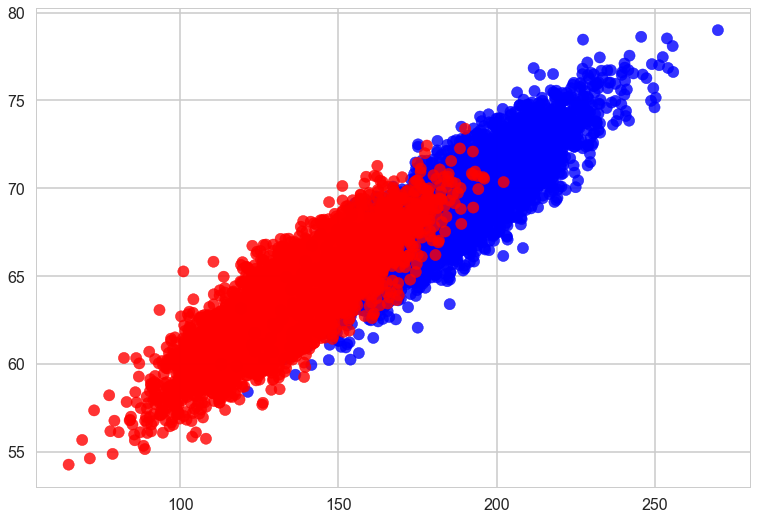

In [3]:
# your turn
print(dflog['Gender'].unique())
print(cm_bright.colors)
cm_bright
plt.scatter(dflog['Weight'],dflog['Height'],c=[cm_bright.colors[i] for i in dflog.Gender=="Male"],alpha=0.8)

### Training and Test Datasets

When fitting models, we would like to ensure two things:

* We have found the best model (in terms of model parameters).
* The model is highly likely to generalize i.e. perform well on unseen data.

<br/>
<div class="span5 alert alert-success">
<h4>Purpose of splitting data into Training/testing sets</h4>
<ul>
  <li> We built our model with the requirement that the model fit the data well. </li>
  <li> As a side-effect, the model will fit <b>THIS</b> dataset well. What about new data? </li>
    <ul>
      <li> We wanted the model for predictions, right?</li>
    </ul>
  <li> One simple solution, leave out some data (for <b>testing</b>) and <b>train</b> the model on the rest </li>
  <li> This also leads directly to the idea of cross-validation, next section. </li>  
</ul>
</div>

First, we try a basic Logistic Regression:

* Split the data into a training and test (hold-out) set
* Train on the training set, and test for accuracy on the testing set

### AJS Notes:

I want to call attention to the fact that in the original statement below, some objects are being created dynamically and then passed to ```train_test_split```. So, I am commenting out the original statement and explicitly showing what these objects are (i.e., their type and shape)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# AJS: commenting out the original statement

# Split the data into a training and test set.
#Xlr, Xtestlr, ylr, ytestlr = train_test_split(dflog[['Height','Weight']].values, 
#                                              (dflog.Gender == "Male").values,random_state=5)

# AJS: define the first parameter and see what it is
X = dflog[['Height','Weight']].values
print("X: ", type(X), X.shape)

('X: ', <type 'numpy.ndarray'>, (10000L, 2L))


### AJS Notes:
Notice that ```X``` is a ```numpy``` array with 10000 rows and 2 columns (a.k.a. a matrix). Now, that should be the exact shape of the dataframe we are using to build the matrix; and indeed ...

In [5]:
# what is the shape of the dataframe used to build X?
dflog[['Height','Weight']].shape

(10000, 2)

### AJS Notes:
Exactly as expected! We now try with the second parameter of ```train_test_split``` ...

In [6]:
# AJS: define the second parameter, investigate its type and shape
# and also compare its shape with that of the dataframe it comes from ...
y = (dflog.Gender == "Male").values

# notice that, by construction, y will have value True in positions where
# the value for the "Gender" column of the dataframe is "Male", and False
# otherwise

print("y: ", type(y), y.shape)
print("dflog.Gender shape: ", dflog.Gender.shape)


('y: ', <type 'numpy.ndarray'>, (10000L,))
('dflog.Gender shape: ', (10000L,))


### AJS Notes:
Exactly as expected! The second parameter, ```y```, is a vector of 10000 components. Moreover, I invite you to check that the following relationship holds between ```X``` and ```y```:

1. They have the same number of rows
2. For a given row ```i``` of matrix ```X```, the label that corresponds to that data point is exactly the value of vector ```y``` at that row
3. The number of rows of ```X``` is the number of data points in the dataset
4. The number of columns of ```X``` is the number of features of each data point in the dataset

Now we can build the split with ```X``` and ```y``` ...

In [7]:
# AJS: Split the data into a training and test set.
Xlr, Xtestlr, ylr, ytestlr = train_test_split(X, y, random_state=5)

### AJS:
At this point, I would like to pause to make the following observation. ***All classification problems can be represented, as shown above, with a matrix ```X``` and a vector  ```y```, satisfying the conditions 1-4 above***. When the number of unique values of ```y``` is 2, the problem is called a binary classification problem. When this number is greater than 2, the problem is called a multi-class classification problem. In this mini-project we are dealing with the former.

Once the split is made, we can see the objects it returned.

In [8]:
# AJS:
print("\n")
print("Xlr:", Xlr, type(Xlr), Xlr.shape, len(Xlr)) #TrainX

# AJS:
print("\n")
print("Xtestlr", Xtestlr, type(Xtestlr), Xtestlr.shape, len(Xtestlr)) #TestX

# AJS:
print("\n")
print("ylr", ylr, type(ylr), ylr.shape, len(ylr)) #Trainy

# AJS:
print("\n")
print("ytestlr", ytestlr, type(ytestlr), ytestlr.shape, len(ytestlr)) #Testy

# AJS:
# By default train_test_split splits to 75% train and 25% test
# Random state set to a fixed number wil guarantee 
# that the output of Run 1 will be equal to the output of Run 2, 
# i.e. your split will be always the same



('Xlr:', array([[  66.67436003,  132.00428008],
       [  64.65940371,  141.89306475],
       [  61.61019345,  112.07761532],
       ..., 
       [  70.62675272,  196.41598318],
       [  71.41075432,  189.20480254],
       [  69.24164203,  192.10003602]]), <type 'numpy.ndarray'>, (7500L, 2L), 7500)


('Xtestlr', array([[  64.22887005,  140.99771493],
       [  73.53028481,  222.9259167 ],
       [  74.35044373,  204.41295958],
       ..., 
       [  60.0901747 ,  117.89523739],
       [  63.23241937,  131.90607094],
       [  70.66233952,  189.13970568]]), <type 'numpy.ndarray'>, (2500L, 2L), 2500)


('ylr', array([False, False, False, ...,  True,  True,  True], dtype=bool), <type 'numpy.ndarray'>, (7500L,), 7500)


('ytestlr', array([False,  True,  True, ..., False, False,  True], dtype=bool), <type 'numpy.ndarray'>, (2500L,), 2500)


### AJS:
As expected ...
1. ```Xlr``` (the training set) is a matrix with 7500 rows and 2 columns--i.e., 75% of the dataset
2. ```ylr``` is the corresponding label vector for the training dataset
3. ```Xtestlr``` (the testing set) is a matrix with 2500 rows and 2 columns--i.e., 25% of the dataset
4. ```ytestlr``` is the corresponding label vector for the testing dataset

In [9]:
# AJS: construct the LogisticRegression model
clf = LogisticRegression()

# Fit the model on the training data.
clf.fit(Xlr, ylr) 

# Print the accuracy from the testing data.
# AJS: introduce variable to be reused later
y_predict_test = clf.predict(Xtestlr)
print("\n")
print("[Test] Accuracy score (y_predict_test, ytestlr):",accuracy_score(y_predict_test, ytestlr))

# AJS: Note the order in which the parameters must be passed
# according to the documentation ... although there should be
# no difference since it is a one-to-one comparison ...
# ref: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score
print("\n")
print("[Test] Accuracy score: (ytestlr, y_predict_test)",accuracy_score(ytestlr, y_predict_test))

# AJS: also printout the training score
y_predict_training = clf.predict(Xlr)
print("\n")
print("[Training] Accuracy score: (ylr, y_predict_training)",accuracy_score(ylr, y_predict_training))



('[Test] Accuracy score (y_predict_test, ytestlr):', 0.92520000000000002)


('[Test] Accuracy score: (ytestlr, y_predict_test)', 0.92520000000000002)


('[Training] Accuracy score: (ylr, y_predict_training)', 0.91679999999999995)


### AJS Notes:
It is common practice to show--when applicable--performance metrics for both the training set and the test set.
This means that the model is fitted with the training set, and once fitted, predictions are generated using
the training set and the test set, and the corresponding performance metrics are shown (as above), and analyzed
(see below.)

Since the model's **training accuracy** (```0.92520000000000002```) is pretty good (meaning, very close to 1--or 100%), then one says there is no "bias" in the model.

Since the model's **test accuracy** (```0.91679999999999995```) is pretty close to the training accuracy, then one says that there is no "variance"
between the training accuracy and the test accuracy. This is an indication that the model will "generalize well",
which means that the model will be well-behaved when new data is presented to it.

These two properties are important and desirable.

When the training accuracy is good, and the test accuracy is not close to the training accuracy (in the sense that test accuracy is worse), then one says the model is "overfitting" the training set. In this case, there is no overfitting.
When there is evidence of overfitting, one must analyze the situation and suggest the course of action, typically aimed
at "relaxing" the model--i.e., making it less strict.

Typically, the test accuracy, even when it is close to the training accuracy, tends to be smaller (worse) than the training accuracy (better). Notice that this is not the case here: the test accuracy is slightly better than the training accuracy.

When the test accuracy is significally better than the training accuracy, this would justify a review of the code to see if there is a bug. Plotting the performance results with multiple splits of the same kind would also be a good idea.

The code below shows one simple way to do it.

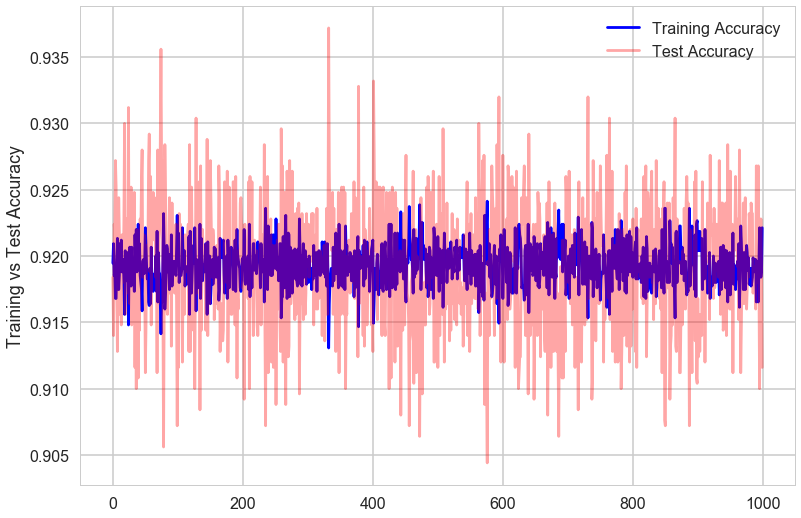

In [10]:
# AJS: we try multiple splits and see the effects, with the same proportion 75% train and 25% test

# keep lists for training accuracy, test accuracy, and the difference
# between the latter and the former
training_accuracy = []
test_accuracy = []
accuracy_difference = []

# define number of trials
n_splits = 1000

# define LogisticRegression object
clf = LogisticRegression()

# loop over multiple trials
for i in range(0, n_splits):
    # do split for this iteration, using shuffle and a different random_state 
    # for every iteration
    Xlr, Xtestlr, ylr, ytestlr = train_test_split(dflog[['Height','Weight']].values, 
                                              (dflog.Gender == "Male").values,random_state=i)
    # fit on the training set
    clf.fit(Xlr, ylr)
    
    # predict on training set
    y_predict_training = clf.predict(Xlr)
    
    # predict on test set
    y_predict_test = clf.predict(Xtestlr)
    
    # save training accuracy for this split
    tr_accuracy = accuracy_score(y_predict_training, ylr)
    training_accuracy.append(tr_accuracy)
    
    # save test accuracy for this split
    tst_accuracy = accuracy_score(y_predict_test, ytestlr)
    test_accuracy.append(tst_accuracy)
    
    # save difference
    accuracy_difference.append(tst_accuracy - tr_accuracy)
#end for
#
# plot both curves
# ref: https://matplotlib.org/users/pyplot_tutorial.html
# parameter alpha below is a percentage of transparency
# ref: https://matplotlib.org/users/legend_guide.html
training_plot, = plt.plot(training_accuracy, 'b')
test_plot, = plt.plot(test_accuracy, 'r', alpha = 0.35)
plt.legend([training_plot, test_plot], ['Training Accuracy', 'Test Accuracy'])
plt.ylabel('Training vs Test Accuracy')
plt.show()

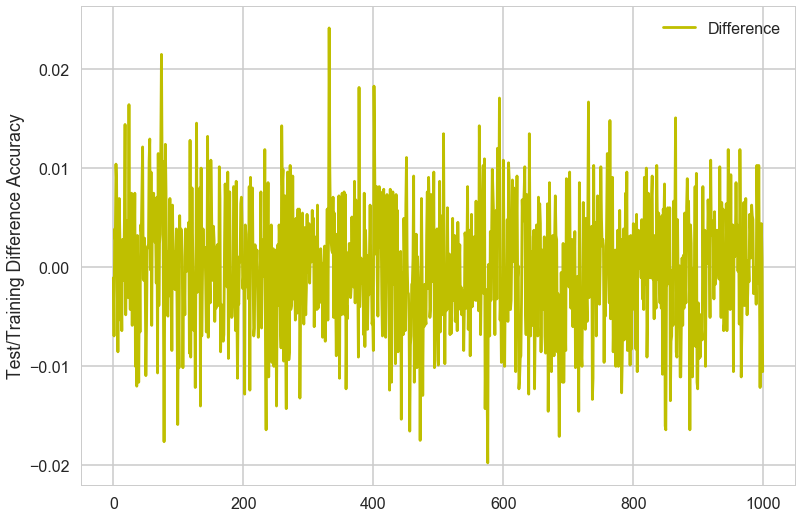

In [11]:
# AJS: show accuracy difference plot
diff_plot, = plt.plot(accuracy_difference, 'y')
plt.legend([diff_plot], ['Difference'])
plt.ylabel('Test/Training Difference Accuracy')
plt.show()

### AJS Notes:
In this case, the test accuracy is consistently better (with a maximum difference of no more than 0.03 units), which is not common--but not that large, either.
This is probably explained by the fact that the dataset is expected to be already pretty linear (height and weight).

Nevertheless, accuracy alone is usually not a reliable metric that can be used to assess the performance of a classification model. Other metrics are shown below.
We could use the same technique illustrated in the previous cell, to graph multiple classification performance metrics.

In [12]:
# AJS: use sklearn.metrics.classification_report for a more comprehensive
# performance analysis

#AJS
from sklearn.metrics import classification_report
# ref: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report

print("[Training Classification Report:]")
print(classification_report(ylr, y_predict_training))

print("[Test Classification Report:]")
print(classification_report(ytestlr, y_predict_test))

[Training Classification Report:]
             precision    recall  f1-score   support

      False       0.92      0.92      0.92      3736
       True       0.92      0.92      0.92      3764

avg / total       0.92      0.92      0.92      7500

[Test Classification Report:]
             precision    recall  f1-score   support

      False       0.91      0.91      0.91      1264
       True       0.91      0.91      0.91      1236

avg / total       0.91      0.91      0.91      2500



### AJS Notes:
With the more detailed classification report, we see that training performance metrics are--as expected--slightly better than their test set counterpart. The ISLR book (http://www-bcf.usc.edu/~gareth/ISL/) has explanations of the meaning of these performance metrics. If I recall correctly, the Wikipedia entries for them are also quite good.